# Load data

In [21]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
# Load and split data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.adult(), test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=0
)

# Data scaling
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist()
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train.values)
X_val = ss.transform(X_val.values)
X_test = ss.transform(X_test.values)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Train model

In [23]:
import pickle
import os.path
import lightgbm as lgb

In [24]:
if os.path.isfile("census model.pkl"):
    print("Loading saved model")
    with open("census model.pkl", "rb") as f:
        model = pickle.load(f)

else:
    # Setup
    params = {
        "max_bin": 512,
        "learning_rate": 0.05,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "num_leaves": 10,
        "verbose": -1,
        "min_data": 100,
        "boost_from_average": True,
    }

    # More setup
    d_train = lgb.Dataset(X_train, label=Y_train)
    d_val = lgb.Dataset(X_val, label=Y_val)

    # Train model
    model = lgb.train(
        params,
        d_train,
        10000,
        valid_sets=[d_val],
        early_stopping_rounds=50,
        verbose_eval=1000,
    )

    # Save model
    with open("census model.pkl", "wb") as f:
        pickle.dump(model, f)

Loading saved model


# Train surrogate

In [25]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss

In [26]:
# Select device
device = torch.device("cuda")

In [27]:
# Check for model
if os.path.isfile("census surrogate.pt"):
    print("Loading saved surrogate model")
    surr = torch.load("census surrogate.pt").to(device)
    surrogate = Surrogate(surr, num_features)

else:
    # Create surrogate model
    surr = nn.Sequential(
        MaskLayer1d(value=0, append=True),
        nn.Linear(2 * num_features, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 128),
        nn.ELU(inplace=True),
        nn.Linear(128, 2),
    ).to(device)

    # Set up surrogate object
    surrogate = Surrogate(surr, num_features)

    # Set up original model
    def original_model(x):
        pred = model.predict(x.cpu().numpy())
        pred = np.stack([1 - pred, pred]).T
        return torch.tensor(pred, dtype=torch.float32, device=x.device)

    # Train
    surrogate.train_original_model(
        X_train,
        X_val,
        original_model,
        batch_size=64,
        max_epochs=100,
        loss_fn=KLDivLoss(),
        validation_samples=10,
        validation_batch_size=10000,
        verbose=True,
    )

    # Save surrogate
    surr.cpu()
    torch.save(surr, "census surrogate.pt")
    surr.to(device)

Loading saved surrogate model


# Train FastSHAP

In [28]:
from fastshap import FastSHAP

In [29]:
# Check for model
if os.path.isfile("census explainer.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("census explainer.pt").to(device)
    fastshap = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

else:
    # Create explainer model
    explainer = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2 * num_features),
    ).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

    # Train
    fastshap.train(
        X_train,
        X_val[:100],
        batch_size=32,
        num_samples=32,
        max_epochs=200,
        validation_samples=128,
        verbose=True,
    )

    # Save explainer
    explainer.cpu()
    torch.save(explainer, "census explainer.pt")
    explainer.to(device)

Loading saved explainer model


# Compare with KernelSHAP

In [30]:
import matplotlib.pyplot as plt

In [31]:
# Setup for KernelSHAP
def imputer(x, S):
    x = torch.tensor(x, dtype=torch.float32, device=device)
    S = torch.tensor(S, dtype=torch.float32, device=device)
    pred = surrogate(x, S).softmax(dim=-1)
    return pred.cpu().data.numpy()

In [32]:
# Select example
ind = np.random.choice(len(X_test))
x = X_test[ind : ind + 1]
y = int(Y_test[ind])

# Run FastSHAP
fastshap_values = fastshap.shap_values(x)[0]

# Run KernelSHAP to convergence
game = shapreg.games.PredictionGame(imputer, x)
shap_values, all_results = shapreg.shapley.ShapleyRegression(
    game,
    batch_size=32,
    paired_sampling=False,
    detect_convergence=True,
    bar=True,
    return_all=True,
)

100%|██████████| 1/1 [00:00<00:00,  5.06it/s]     


In [33]:
print(fastshap.shap_values(x))

[[[-0.08135784  0.0841713 ]
  [ 0.00058855  0.0004276 ]
  [ 0.02371024 -0.02391866]
  [ 0.09646441 -0.096312  ]
  [-0.01406367  0.01209459]
  [ 0.12867607 -0.12808171]
  [ 0.00301377 -0.00197414]
  [-0.02983568  0.03087496]
  [ 0.02310633 -0.02602659]
  [ 0.00632257 -0.00624981]
  [ 0.00963315 -0.01036952]
  [ 0.00029651 -0.00119051]]]


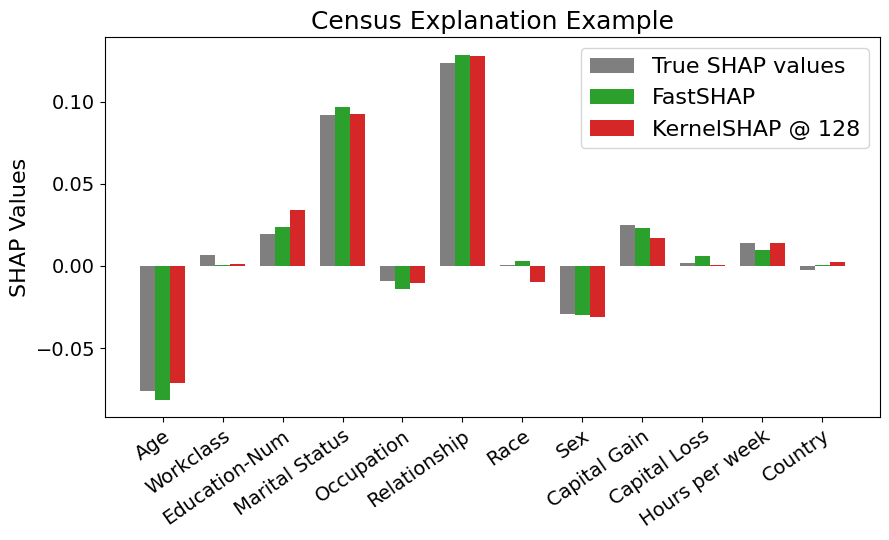

In [34]:
# Create figure
plt.figure(figsize=(9, 5.5))

# Bar chart
width = 0.75
kernelshap_iters = 128
plt.bar(
    np.arange(num_features) - width / 3,
    shap_values.values[:, y],
    width / 3,
    label="True SHAP values",
    color="tab:gray",
)
plt.bar(
    np.arange(num_features),
    fastshap_values[:, y],
    width / 3,
    label="FastSHAP",
    color="tab:green",
)
plt.bar(
    np.arange(num_features) + width / 3,
    all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][:, y],
    width / 3,
    label="KernelSHAP @ {}".format(kernelshap_iters),
    color="tab:red",
)

# Annotations
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.ylabel("SHAP Values", fontsize=16)
plt.title("Census Explanation Example", fontsize=18)
plt.xticks(
    np.arange(num_features),
    feature_names,
    rotation=35,
    rotation_mode="anchor",
    ha="right",
)

plt.tight_layout()
plt.show()

# Comparison Plot

In [35]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting function
def plot_shapley_comparison(evals, mean_distances, std_errors, title):
    plt.figure(figsize=(20, 8))
    for method, mean in mean_distances.items():
        std_error = std_errors[method]
        plt.plot(evals, mean, label=method)
        mean = np.array(mean)
        std_error = np.array(std_error)
        plt.fill_between(evals, mean - std_error, mean + std_error, alpha=0.2)

    plt.xlabel("# Evals", fontsize=20)
    plt.ylabel("Mean $\\ell_2$ distance", fontsize=20)
    plt.title(title, fontsize=20)
    # put the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=20)

    # set y lim
    # plt.ylim(0, 2)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.show()

In [36]:
import dill

dumped_shap_values = dill.load(open("./shap_values.pkl", "rb"))
dumped_results = dill.load(open("./results.pkl", "rb"))
dumped_indexes = dill.load(open("./indexes.pkl", "rb"))

In [45]:
dumped_results[0]["values"][0]

array([[ 0.01175709, -0.01175714],
       [ 0.00073394, -0.00073396],
       [-0.00175002,  0.00175006],
       [ 0.00249525, -0.00249522],
       [ 0.00436348, -0.00436348],
       [-0.01175424,  0.01175424],
       [-0.00071559,  0.00071558],
       [ 0.00647311, -0.00647313],
       [ 0.00994567, -0.00994568],
       [ 0.00038597, -0.00038592],
       [ 0.00611091, -0.00611089],
       [-0.00789083,  0.00789083]])

In [48]:
list(dumped_results[0]["iters"]).index(32)

0

In [55]:
results_mean = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_tuned": [],
}

results_std = {
    "kernel_shap": [],
    "fastshap": [],
    "fastshap_tuned": [],
}
iters = []
first = True
fastshap_values = []
true_shap_values = []

for kernelshap_iters in range(32, 672, 32):
    iters.append(kernelshap_iters)
    kernel_shap_values = []
    correct_indexes = []

    for ind in dumped_indexes[:-10]:
        x = X_test[ind : ind + 1]
        y = int(Y_test[ind])

        # Run FastSHAP
        if first:
            fastshap_values.append(fastshap.shap_values(x)[0][:, y])
        # Run KernelSHAP to convergence
        # game = shapreg.games.PredictionGame(imputer, x)
        # shap_values, all_results = shapreg.shapley.ShapleyRegression(
        # game,
        # batch_size=32,
        # paired_sampling=False,
        # detect_convergence=True,
        # bar=True,
        # return_all=True,
        # )
        try:
            kernel_shap_values.append(
                # all_results["values"][list(all_results["iters"]).index(kernelshap_iters)][
                #     :, y
                # ]
                dumped_results[ind]["values"][
                    list(dumped_results[ind]["iters"]).index(kernelshap_iters)
                ][:, y]
            )
        except:
            print(kernelshap_iters, ind)

        if first:
            true_shap_values.append(shap_values.values[:, y])
        correct_indexes.append(ind)
    first = False

    true_shap_values = np.array(true_shap_values)
    kernel_shap_values = np.array(kernel_shap_values)
    fastshap_values = np.array(fastshap_values)

    for current_list in [
        (kernel_shap_values, "kernel_shap"),
        (fastshap_values, "fastshap"),
    ]:
        # Compute the L2 distances between corresponding vectors in the two arrays
        distances = np.linalg.norm(current_list[0] - true_shap_values, axis=0)

        # Calculate the mean L2 distance
        mean_l2_distance = np.mean(distances)

        # Calculate the standard error of the L2 distances
        standard_error = np.std(distances) / np.sqrt(len(distances))

        results_mean[current_list[1]].append(mean_l2_distance)
        results_std[current_list[1]].append(standard_error)

In [57]:
# remove key fastshap_tuned from results_mean and from results_std
del results_mean["fastshap_tuned"]
del results_std["fastshap_tuned"]

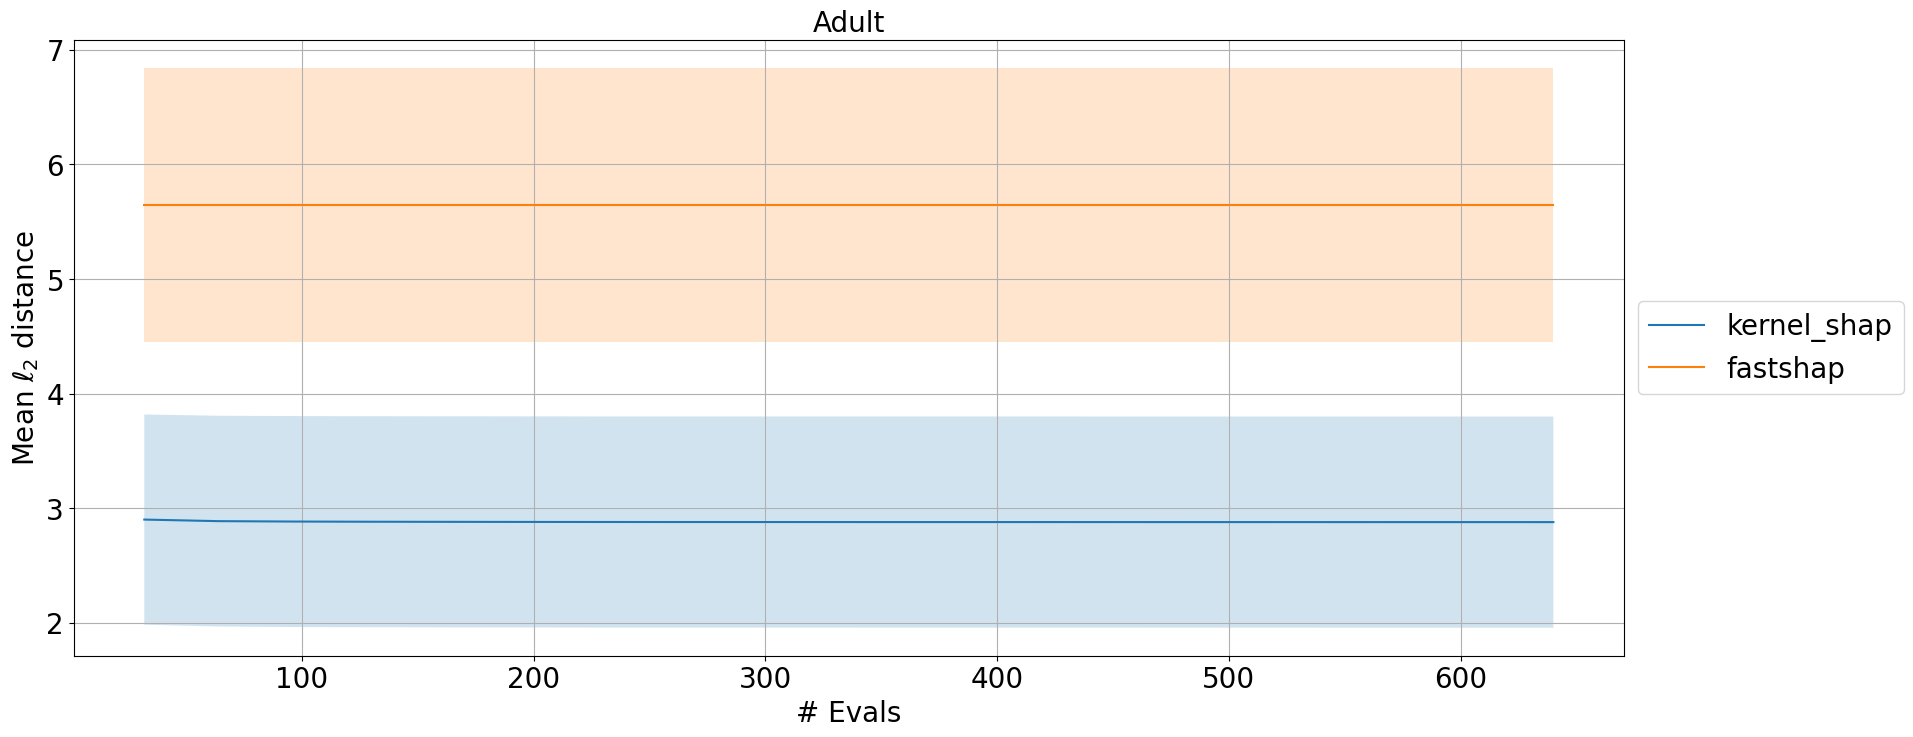

In [58]:
plot_shapley_comparison(iters, results_mean, results_std, "Adult")